In this notebook, the downloaded daily files will be processed into a uniform 0.25 degree grid with a uniform time dimension.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
zarr_grid=xr.open_dataset('../grid.nc')

In [3]:
zarr_time=xr.open_dataset("../time.nc")
date_start=str(zarr_time.time.min().values)[:10]
date_end=str(zarr_time.time.max().values)[:10]

In [4]:
# Load the functions
# standardize_chunk_float64(ds) is here
%run -i "~/indian-ocean-zarr/notebooks/functions.py"

### Load the files, process and save

In [5]:
dataid="cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_regrid"
chloro1 = xr.open_mfdataset(f'~/shared/data/copernicus/{dataid}/*.nc')

In [6]:
chloro1

<xarray.Dataset> Size: 8GB
Dimensions:          (time: 9770, lat: 177, lon: 241)
Coordinates:
  * time             (time) datetime64[ns] 78kB 1997-10-01 ... 2024-06-30
  * lat              (lat) float32 708B 32.0 31.75 31.5 ... -11.5 -11.75 -12.0
  * lon              (lon) float32 964B 42.0 42.25 42.5 ... 101.5 101.8 102.0
Data variables:
    CHL              (time, lat, lon) float32 2GB dask.array<chunksize=(31, 177, 241), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float64 3GB dask.array<chunksize=(31, 177, 241), meta=np.ndarray>
    flags            (time, lat, lon) float64 3GB dask.array<chunksize=(31, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    ...                              ...
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-20T15:24:55Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0
    copernicusmarine_version:        1.3.1

In [7]:
# Fix the time
chloro1_date_start = str(chloro1.time.min().values)[:10]
chloro_interp=chloro1.sel(time=slice(chloro1_date_start, date_end))

In [8]:
# Pad time back to start of the zarr time
timepad=pd.to_datetime(chloro1.time[0].values)-pd.to_datetime(zarr_time.time[0].values)
chloro_interp = chloro_interp.pad(time=(timepad.days,0))
chloro_interp['time']=zarr_time.time.values

In [9]:
# Fix vars to be float32 and chucks to be time 100 days
# Function defined in functions.py
chloro_interp = standardize_float64(chloro_interp)
chloro_interp = standardize_chunk(chloro_interp)

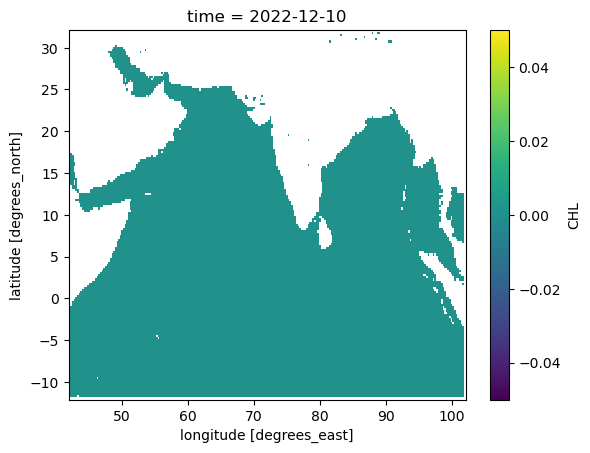

In [32]:
# Check that we did not make a mistake
(chloro_interp['CHL'].sel(time="2022-12-10")-chloro1['CHL'].sel(time="2022-12-10")).plot()

In [30]:
# Take a look
chloro_interp

<xarray.Dataset> Size: 8GB
Dimensions:                  (time: 16071, lat: 177, lon: 241)
Coordinates:
  * time                     (time) datetime64[ns] 129kB 1979-01-01 ... 2022-...
  * lat                      (lat) float32 708B 32.0 31.75 31.5 ... -11.75 -12.0
  * lon                      (lon) float32 964B 42.0 42.25 42.5 ... 101.8 102.0
Data variables:
    CHL-gapfree              (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty-gapfree  (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_flags-gapfree        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    ...                              ...
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-20T15:24:55Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0
    copernicusmarine_version:        1.3.1

In [11]:
chloro_interp = chloro_interp.rename({"CHL": "CHL-gapfree", "CHL_uncertainty": "CHL_uncertainty-gapfree", "flags": "CHL_flags-gapfree"})

In [12]:
from dask.distributed import Client;
client=Client(n_workers=4);
#client.close()

In [24]:
# Add full attributes to the variables
for var in chloro_interp.data_vars:
    chloro_interp[var].attrs.update(chloro_interp.attrs)

In [32]:
# Save data to zarr to preserve chunks
#chloro_interp.to_zarr('~/shared/data/finalized/chlorophyll-gapfree')
chloro_interp.to_zarr('/home/jovyan/shared/data/finalized/chlorophyll.zarr')

In [34]:
# test by opening
xr.open_zarr(f'~/shared/data/finalized/chlorophyll.zarr')

<xarray.Dataset> Size: 8GB
Dimensions:                  (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat                      (lat) float32 708B 32.0 31.75 31.5 ... -11.75 -12.0
  * lon                      (lon) float32 964B 42.0 42.25 42.5 ... 101.8 102.0
  * time                     (time) datetime64[ns] 129kB 1979-01-01 ... 2022-...
Data variables:
    CHL-gapfree              (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_flags-gapfree        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty-gapfree  (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    ...                              ...
    time_coverage_end:               2023-11-22T08:12:52Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-11-20T15:24:55Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

### Repeat for the level 3 data

In [35]:
dataid="cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D_regrid"
chloro1 = xr.open_mfdataset(f'~/shared/data/copernicus/{dataid}/*.nc')
# Fix the time
chloro1_date_start = str(chloro1.time.min().values)[:10]
chloro_interp=chloro1.sel(time=slice(chloro1_date_start, date_end))
# Pad time back to start of the zarr time
timepad=pd.to_datetime(chloro1.time[0].values)-pd.to_datetime(zarr_time.time[0].values)
chloro_interp = chloro_interp.pad(time=(timepad.days,0))
chloro_interp['time']=zarr_time.time.values
# Fix vars to be float32 and chucks to be time 100 days
# Function defined in functions.py
chloro_interp = standardize_float64(chloro_interp)
chloro_interp = standardize_chunk(chloro_interp)
# Relabel
chloro_interp = chloro_interp.rename({"CHL": "CHL-level3", "CHL_uncertainty": "CHL_uncertainty-level3", "flags": "CHL_flags-level3"})
for var in chloro_interp.data_vars:
    chloro_interp[var].attrs.update(chloro_interp.attrs)

In [36]:
#chloro_interp.to_zarr(f'~/shared/data/finalized/chlorophyll-level3')
chloro_interp.to_zarr('/home/jovyan/shared/data/finalized/chlorophyll.zarr', mode='a')

### Create a flag for land and clouds

2 is land, 0 is water/observed, 1 is cloud

In [162]:
ds = xr.open_zarr(f'~/shared/data/finalized/chlorophyll.zarr')
land=np.isnan(ds['CHL-level3'].mean(dim="time"))
land = land.astype('uint8')
ds['CHL-land']=land
dcloud=np.isnan(ds['CHL-level3'])
cloud = cloud.astype('uint8')
ds['CHL-cloud']=cloud+land
ds

<xarray.Dataset> Size: 17GB
Dimensions:                  (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat                      (lat) float32 708B 32.0 31.75 31.5 ... -11.75 -12.0
  * lon                      (lon) float32 964B 42.0 42.25 42.5 ... 101.8 102.0
  * time                     (time) datetime64[ns] 129kB 1979-01-01 ... 2022-...
Data variables:
    CHL-gapfree              (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL-level3               (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_flags-gapfree        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_flags-level3         (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty-gapfree  (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty-level3   (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL-land                 (lat, lon) uint8 43kB dask.array<chunksize=(177, 241), meta=np.ndarray>
    CHL-cloud                (time, lat, lon) uint8 686MB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

In [168]:
vars = ['CHL-land', 'CHL-cloud']
ds = ds[vars]
ds['CHL-land'].attrs['title'] = "flag for CHL-gapfree and CHL-level3. 2 is land; 0 is water"
ds['CHL-cloud'].attrs['title'] = "flag for CHL-gapfree and CHL-level3. 0 is land; 1 is cloud; 0 is water"
ds['CHL-land'] = ds['CHL-land']*2

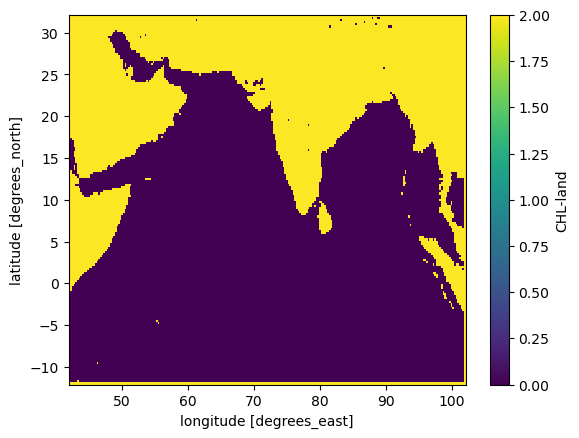

In [169]:
ds['CHL-land'].plot()

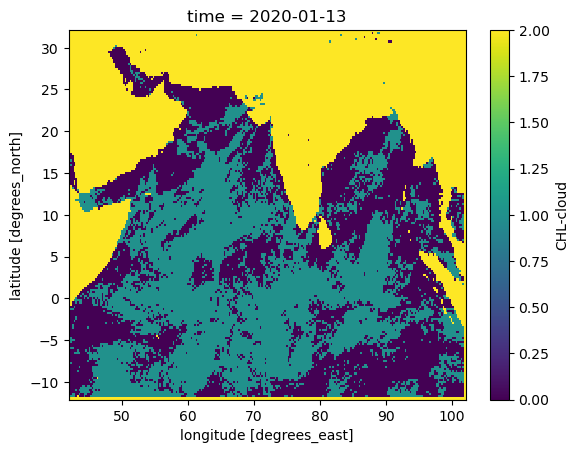

In [149]:
ds['CHL-cloud'].sel(time="2020-01-13").plot()

In [170]:
ds.to_zarr('/home/jovyan/shared/data/finalized/chlorophyll.zarr', mode='a')

### Append variables

In [37]:
chloro_interp.to_zarr('/home/jovyan/shared/data/finalized/chlorophyll.zarr', mode='a')

In [171]:
xr.open_zarr('/home/jovyan/shared/data/finalized/chlorophyll.zarr')

<xarray.Dataset> Size: 17GB
Dimensions:                  (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat                      (lat) float32 708B 32.0 31.75 31.5 ... -11.75 -12.0
  * lon                      (lon) float32 964B 42.0 42.25 42.5 ... 101.8 102.0
  * time                     (time) datetime64[ns] 129kB 1979-01-01 ... 2022-...
Data variables:
    CHL-cloud                (time, lat, lon) uint8 686MB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL-gapfree              (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL-land                 (lat, lon) uint8 43kB dask.array<chunksize=(177, 241), meta=np.ndarray>
    CHL-level3               (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_flags-gapfree        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_flags-level3         (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty-gapfree  (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty-level3   (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

# Wind

In [ ]:
wind_east = xr.open_mfdataset('shared/data/era5/eastward_wind_at_10_metres/*.nc')
wind_north = xr.open_mfdataset('shared/data/era5/northward_wind_at_10_metres/*.nc')

In [ ]:
wind_east = wind_east.rename({'time0':'time', 'eastward_wind_at_10_metres': 'u_wind'})
wind_north = wind_north.rename({'time0':'time', 'northward_wind_at_10_metres': 'v_wind'})

In [ ]:
wind_east

In [ ]:
wind_east.to_netcdf('shared/data/u_comp_wind.nc')
wind_north.to_netcdf('shared/data/v_comp_wind.nc')

In [ ]:
wind_east.load().to_netcdf('shared/data/uwind.nc')

In [ ]:
daily_east = wind_east.coarsen(time=24).mean(keep_attrs=True).compute()

In [ ]:
daily_north = wind_north.coarsen(time=24).mean(keep_attrs=True).compute()

In [ ]:
wind_reanalysis = xr.combine_by_coords([daily_east, daily_north])
wind_reanalysis = wind_reanalysis.assign(speed = np.sqrt(wind_reanalysis.u_wind**2 + wind_reanalysis.v_wind**2))
wind_reanalysis = wind_reanalysis.assign(direction = np.rad2deg(np.arctan2(wind_reanalysis.v_wind, wind_reanalysis.u_wind)))

In [ ]:
wind_reanalysis.time.shape

In [ ]:
wind_reanalysis['direction'].isel(time=1).plot.imshow()

In [ ]:
array_for_interpolation = wind_east.isel(time=0)

In [ ]:
array_for_interpolation.to_netcdf('data/grid.nc')

In [ ]:
wind_reanalysis.chunk({'time': wind_reanalysis.time.shape[0]}).to_zarr('shared/data/wind_all.zarr')

In [ ]:
wind_reanalysis.to_zarr('shared/data/wind_all.zarr')

In [ ]:
wind_reanalysis[['u_wind', 'v_wind']].load().to_netcdf('wind_comp.nc')

## SLA

In [ ]:
sla = xr.open_mfdataset('cop_sla/*.nc')

In [ ]:
sla

In [ ]:
# Interpolating
interp = sla.rename({"latitude": "lat", "longitude": "lon"}).interp_like(array_for_interpolation)

In [ ]:
interp

In [ ]:
interp.to_netcdf('shared/data/sla.nc')

## Rest of ERA5

In [ ]:
xr.open_dataset('shared/data/era5/air_temperature_at_2_metres/200001.nc')

In [ ]:
vars = {'air_temperature_at_2_metres': 'air_temp_2m', 'sea_surface_temperature': 'sst'}
for var, new_name in vars.items():
    ds = xr.open_mfdataset(f'shared/data/era5/{var}/*.nc')
    ds = ds.rename({'time0':'time', var: new_name})
    ds = ds.coarsen(time=24).mean(keep_attrs=True).compute()
    ds.to_netcdf(f'shared/data/finalized/{new_name}.nc')
    print('done1...')

In [ ]:
xr.open_dataset('shared/data/finalized/sst.nc')

## Topography

In [ ]:
topo = xr.open_dataarray('data/topography.nc')

In [ ]:
grid = xr.open_dataarray('data/grid.nc')

In [ ]:
topo = topo.rename({'latitude': 'lat', 'longitude': 'lon'})

In [ ]:
topo_interp = topo.interp_like(grid)

In [ ]:
topo_interp.to_netcdf('shared/data/finalized/topography.nc')

In [ ]:
topo_interp.plot.imshow()

In [ ]:
grid

## Geostrophic & surface currents

In [ ]:
ocean_currents = xr.open_mfdataset('earthdata/OSCAR_L4_OC_FINAL_V2.0/*.nc')

In [ ]:
ocean_currents = ocean_currents.transpose('time', 'latitude', 'longitude')

In [ ]:
ocean_currents['time'] = ocean_currents.indexes['time'].to_datetimeindex()

In [ ]:
ocean_currents_modified =ocean_currents.rename({'longitude': 'lon', 'latitude': 'lat'})

In [ ]:
unique_idxs = np.unique(ocean_currents.time, return_index=True)[1]

In [ ]:
unique_idxs.shape

In [ ]:
ocean_currents = ocean_currents.isel(time=unique_idxs)
ocean_currents_modified = ocean_currents_modified.isel(time=unique_idxs)

In [ ]:
ocean_currents.to_netcdf('shared/data/finalized/currents.nc')
ocean_currents_modified.to_netcdf('shared/data/finalized/currents_modified.nc')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
ocean_currents['ug'].isel(time=0).plot.imshow(ax=axs[0], vmin=-3, cmap='seismic_r', vmax=3, center=0)
ocean_currents['u'].isel(time=0).plot.imshow(ax=axs[1], vmin=-3, cmap='seismic_r',vmax=3, center=0)
axs[0].set_title('geostrophic current')
axs[1].set_title('non geostrophic current')

## Transforming coordinates

In [ ]:
hell = xr.open_dataset('shared/data/finalized/currents.nc')

In [ ]:
hell

In [ ]:
hell = hell.reindex(latitude=hell.latitude.values[::-1])

In [ ]:
hell

Use another dataset with the same coordinate sets as dub to fix the indexing issues for the geostrophic/surface current dataset. In this case, use the SLA data

In [ ]:
sla = xr.open_dataset('shared/data/finalized/sla.nc')

In [ ]:
sla

In [ ]:
helled = hell.interp_like(grid)

In [ ]:
helled.u.values

In [ ]:
sla['u'] = (['time', 'lat', 'lon'],  np.flip(hell['u'].values, 1))
sla['v'] = (['time', 'lat', 'lon'],  np.flip(hell['v'].values, 1))
sla['ug'] = (['time', 'lat', 'lon'],  np.flip(hell['ug'].values, 1))
sla['vg'] = (['time', 'lat', 'lon'], np.flip(hell['vg'].values, 1))

In [ ]:
sla['u_flipped'] = (['time', 'lat', 'lon'],  np.flip(hell['u'].values, 1))

In [ ]:
# already dropped the other variables. Ready to export
sla

Double check the accuracy

In [ ]:
sla.u.isel(time=0).plot.imshow()

In [ ]:
# export 
sla.to_netcdf('shared/data/finalized/currents.nc')

# Combine all features together

In [5]:
wind = xr.open_zarr('shared/data/finalized/wind_all.zarr') # reanalysis

In [4]:
## Change time coordinates for reanalysis datasets

In [5]:
reanalysis = xr.combine_by_coords([wind, sst, air_temp])

In [6]:
reanalysis = reanalysis.assign_coords(time=np.arange('2000-01-01', '2021-01-01', timedelta(days=1),dtype='datetime64[ns]'))

In [8]:
currents = xr.open_dataset('data/earthdata/OSCAR_L4_OC_FINAL_V2.0/2000_processed.nc')

In [9]:
chloro

NameError: name 'chloro' is not defined

In [35]:
reanalysis

<xarray.Dataset>
Dimensions:      (lon: 241, lat: 177, time: 7671)
Coordinates:
  * lon          (lon) float32 42.0 42.25 42.5 42.75 ... 101.2 101.5 101.8 102.0
  * lat          (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Data variables:
    air_temp_2m  (time, lat, lon) float32 286.4 286.1 286.1 ... 300.3 300.2
    direction    (time, lat, lon) float32 dask.array<chunksize=(959, 23, 31), meta=np.ndarray>
    speed        (time, lat, lon) float32 dask.array<chunksize=(959, 23, 31), meta=np.ndarray>
    u_wind       (time, lat, lon) float32 dask.array<chunksize=(959, 23, 31), meta=np.ndarray>
    v_wind       (time, lat, lon) float32 dask.array<chunksize=(959, 23, 31), meta=np.ndarray>
    sst          (time, lat, lon) float32 nan nan nan nan ... 301.4 301.4 301.4
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts

In [22]:
sla

<xarray.Dataset>
Dimensions:  (time: 7671, lat: 177, lon: 241)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lon      (lon) float32 42.0 42.25 42.5 42.75 ... 101.2 101.5 101.8 102.0
  * lat      (lat) float32 32.0 31.75 31.5 31.25 ... -11.25 -11.5 -11.75 -12.0
Data variables:
    sla      (time, lat, lon) float64 ...
    adt      (time, lat, lon) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1999-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

## Problem with merging, going to settle down by manually copy-paste objects into one united object!

In [10]:
# only applied for data that has same dimensions but different attributes
def combine_transposed(target_arr, list_of_objs):
    target_dim_order = list(target_arr.dims.keys())
    print(target_dim_order)
    for obj in list_of_objs:
        vars_ = [i for i in obj.data_vars]
        obj_transposed = obj[target_dim_order+ vars_]
        # print(obj_transposed)
        for var in vars_:
            print(var)
            target_arr[var] = (['time', 'lat', 'lon'], obj_transposed[var].values)
    return target_arr

In [11]:
objs = [sla, chloro, currents]
re = combine_transposed(reanalysis, [sla, currents, chloro])

['lon', 'lat', 'time']
sla
adt
u
v
ug
vg
CHL_uncertainty
CHL


In [12]:
re

<xarray.Dataset>
Dimensions:          (lon: 241, lat: 177, time: 7671)
Coordinates:
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Data variables: (12/14)
    air_temp_2m      (time, lat, lon) float32 ...
    direction        (time, lat, lon) float32 dask.array<chunksize=(959, 23, 31), meta=np.ndarray>
    speed            (time, lat, lon) float32 dask.array<chunksize=(959, 23, 31), meta=np.ndarray>
    u_wind           (time, lat, lon) float32 dask.array<chunksize=(959, 23, 31), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(959, 23, 31), meta=np.ndarray>
    sst              (time, lat, lon) float32 ...
    ...               ...
    u                (time, lat, lon) float64 nan nan nan ... -0.1321 -0.1653
    v                (time, lat, lon) float64 nan nan nan ... -0.04379 -0.06676
    ug               (time, lat, lon) float64 nan nan nan ... -0.09519 -0.1259
    vg               (time, lat, lon) float64 nan nan nan ... -0.03359 -0.05587
    CHL_uncertainty  (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    CHL              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts

In [4]:
# netcdf file export will be super heavy, so saving to pickle in case anything happens...?
# with open('data/re.pickle', 'wb') as handle:
#     pickle.dump(re, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Export final file

In [3]:
sla = xr.open_dataset('shared/data/finalized/sla.nc')
sst = xr.open_dataset('shared/data/finalized/sst.nc') # reanalysis
air_temp = xr.open_dataarray('shared/data/finalized/air_temp_2m.nc') # reanalysis
chloro = xr.open_dataset('shared/data/finalized/chlorophyll-a.nc')
currents = xr.open_dataset('data/earthdata/OSCAR_L4_OC_FINAL_V2.0/2000_processed.nc')

In [4]:
with open('data/re.pickle', 'rb') as handle:
    re = pickle.load(handle)

## Editing metadata

In [5]:
re = re.rename({'u': 'u_curr', 'v': 'v_curr', 'ug': 'ug_curr', 'vg': 'vg_curr', 'air_temp_2m': 'air_temp'})

In [6]:
re['speed'].attrs = {
    'units': 'm s**-1',
    'long_name': '10 metre absolute speed'
}

re['direction'].attrs = {
    'units': '°C',
    'long_name': '10 metre wind direction'
}

re['CHL_uncertainty'].attrs = chloro['CHL_uncertainty'].attrs

re['CHL'].attrs = chloro['CHL'].attrs


re.u_curr.attrs = currents.u.attrs
re.v_curr.attrs = currents.v.attrs
re.ug_curr.attrs = currents.ug.attrs
re.vg_curr.attrs = currents.vg.attrs


re.sla.attrs = sla.sla.attrs
re.adt.attrs = sla.adt.attrs
re.time.attrs = currents.time.attrs

In [7]:
re.attrs = {
    'title': 'Climate Data for Coastal Upwelling Machine Learning Project in Indian Ocean',
    'summary': "Daily mean of 0.25 x 0.25 degrees gridded data from multiple climate variables that may influence the patterns of coastal upwelling in the focused area",
    'creator_name': 'Minh Phan',
    'creator_email': 'minhphan@uw.edu',
    'creator_type': 'person',
    'source': 'OSCAR, ERA5 Reanalysis, Copernicus Climate Change Service (C3S), Copernicus Marine Environment Monitoring Service (CMEMS)',
    'geospatial_lat_min': -12.0,
    'geospatial_lat_max': 32.0,
    'geospatial_lat_units': 'degrees_north',
    'geospatial_lat_resolution': 0.25,
    'geospatial_lon_min': 42.0,
    'geospatial_lon_max': 102.0,
    'geospatial_lon_units': 'degrees_east',
    'geospatial_lon_resolution': 0.25,
    'time_coverage_start': '2000-01-01T00:00:00',
    'time_coverage_end': '2020-12-31T23:59:59',
    'date_created': '2023-07-07'
}

In [8]:
re

<xarray.Dataset>
Dimensions:          (lon: 241, lat: 177, time: 7671)
Coordinates:
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Data variables: (12/14)
    air_temp         (time, lat, lon) float32 ...
    direction        (time, lat, lon) float32 dask.array<chunksize=(959, 23, 31), meta=np.ndarray>
    speed            (time, lat, lon) float32 dask.array<chunksize=(959, 23, 31), meta=np.ndarray>
    u_wind           (time, lat, lon) float32 dask.array<chunksize=(959, 23, 31), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(959, 23, 31), meta=np.ndarray>
    sst              (time, lat, lon) float32 ...
    ...               ...
    u_curr           (time, lat, lon) float64 nan nan nan ... -0.1321 -0.1653
    v_curr           (time, lat, lon) float64 nan nan nan ... -0.04379 -0.06676
    ug_curr          (time, lat, lon) float64 nan nan nan ... -0.09519 -0.1259
    vg_curr          (time, lat, lon) float64 nan nan nan ... -0.03359 -0.05587
    CHL_uncertainty  (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    CHL              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes: (12/17)
    title:                      Climate Data for Coastal Upwelling Machine Le...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    creator_name:               Minh Phan
    creator_email:              minhphan@uw.edu
    creator_type:               person
    source:                     OSCAR, ERA5 Reanalysis, Copernicus Climate Ch...
    ...                         ...
    geospatial_lon_max:         102.0
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2020-12-31T23:59:59
    date_created:               2023-07-07

In [9]:
# chunk_size = {'time': 100, 'lat': 177, 'lon': 241}
# chunk with time=100 time stamps
re_computed = re.isel(time=slice(0,100)).compute()

In [10]:
re_computed.load()

<xarray.Dataset>
Dimensions:          (lon: 241, lat: 177, time: 100)
Coordinates:
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-04-09
Data variables: (12/14)
    air_temp         (time, lat, lon) float32 286.4 286.1 286.1 ... 299.7 299.7
    direction        (time, lat, lon) float32 -41.19 -45.94 ... 166.2 170.7
    speed            (time, lat, lon) float32 1.297 1.166 1.428 ... 4.58 4.452
    u_wind           (time, lat, lon) float32 0.9761 0.8111 ... -4.448 -4.393
    v_wind           (time, lat, lon) float32 -0.8542 -0.8382 ... 1.094 0.7188
    sst              (time, lat, lon) float32 nan nan nan ... 302.2 302.2 302.3
    ...               ...
    u_curr           (time, lat, lon) float64 nan nan nan ... 0.07824 0.0496
    v_curr           (time, lat, lon) float64 nan nan nan ... -0.5402 -0.5223
    ug_curr          (time, lat, lon) float64 nan nan nan ... 0.1027 0.07136
    vg_curr          (time, lat, lon) float64 nan nan nan ... -0.5077 -0.4847
    CHL_uncertainty  (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    CHL              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes: (12/17)
    title:                      Climate Data for Coastal Upwelling Machine Le...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    creator_name:               Minh Phan
    creator_email:              minhphan@uw.edu
    creator_type:               person
    source:                     OSCAR, ERA5 Reanalysis, Copernicus Climate Ch...
    ...                         ...
    geospatial_lon_max:         102.0
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2020-12-31T23:59:59
    date_created:               2023-07-07

In [11]:
# convert all variables with float64 to float32
float64_vars = ['sla', 'adt', 'u_curr', 'v_curr', 'ug_curr', 'vg_curr']
for var in float64_vars:
    re_computed[var].values = re_computed[var].astype('float32')

In [12]:
re_computed['speed'].encoding

{'chunks': (959, 23, 31),
 'preferred_chunks': {'time': 959, 'lat': 23, 'lon': 31},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float32')}

In [13]:
# rechunk every thing
array_chunk_size = {'time': 100, 'lat': 177, 'lon': 241}
chunks_to_delete = ['speed', 'direction', 'u_wind', 'v_wind']
for var in chunks_to_delete:
    del re_computed[var].encoding['chunks']

In [14]:
re_computed = re_computed.chunk(array_chunk_size)

## Export data

In [39]:
# divide by chunks to save data... chunk_size=100 days, then append to zarr files

In [15]:
re_computed.to_zarr('shared/data/final_2.zarr')

In [17]:
def final_processing(re_computed):
    # convert float64 to float32 for consistency
    float64_vars = ['sla', 'adt', 'u_curr', 'v_curr', 'ug_curr', 'vg_curr']
    for var in float64_vars:
        re_computed[var].values = re_computed[var].astype('float32')

    # delete original chunk size
    array_chunk_size = {'time': 100, 'lat': 177, 'lon': 241}
    chunks_to_delete = ['speed', 'direction', 'u_wind', 'v_wind']
    for var in chunks_to_delete:
        del re_computed[var].encoding['chunks']
        
    # rechunk
    re_computed = re_computed.chunk(array_chunk_size)
    
    return re_computed

In [18]:
print('Saving time index...', end= ' ')
for t_idx in range(100, 7600, 100):
    print(t_idx, end=' ')
    re_computed = re.isel(time=slice(t_idx, t_idx+100)).compute()
    re_computed = final_processing(re_computed)
    re_computed.to_zarr('shared/data/final_2.zarr', append_dim='time', mode='a')

Saving time index... 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 

In [53]:
re_computed = re.isel(time=slice(7600, 7671)).compute()
re_computed = final_processing(re_computed)
re_computed.to_zarr('shared/data/final_2.zarr', append_dim='time', mode='a')

In [5]:
re_computed.to_zarr('shared/data/final.zarr', append_dim='time', mode='a')

# Double check

In [16]:
fd = xr.open_zarr('shared/data/final_copy.zarr/')

In [17]:
fd.attrs

{'creator_email': 'minhphan@uw.edu',
 'creator_name': 'Minh Phan',
 'creator_type': 'person',
 'date_created': '2023-07-07',
 'geospatial_lat_max': 32.0,
 'geospatial_lat_min': -12.0,
 'geospatial_lat_resolution': 0.25,
 'geospatial_lat_units': 'degrees_north',
 'geospatial_lon_max': 102.0,
 'geospatial_lon_min': 42.0,
 'geospatial_lon_resolution': 0.25,
 'geospatial_lon_units': 'degrees_east',
 'source': 'OSCAR, ERA5 Reanalysis, Copernicus Climate Change Service (C3S), Copernicus Marine Environment Monitoring Service (CMEMS)',
 'summary': 'Daily mean of 0.25 x 0.25 degrees gridded data from multiple climate variables that may influence the patterns of coastal upwelling in the focused area',
 'time_coverage_end': '2020-12-31T23:59:59',
 'time_coverage_start': '2000-01-01T00:00:00',
 'title': 'Climate Data for Coastal Upwelling Machine Learning Project in Indian Ocean'}

In [18]:
metadata = fd.attrs
metadata_dict = dict(metadata)

In [19]:
variables = fd.variables
variables_dict = {var_name: fd[var_name].attrs for var_name in variables}

In [20]:
import json
with open('data/metadata.json', 'w') as f:
    json.dump(metadata_dict, f)

with open('data/variables.json', 'w') as f:
    json.dump(variables_dict, f)

In [21]:
fd.attrs.clear()

In [22]:
fd

<xarray.Dataset>
Dimensions:          (time: 7671, lat: 177, lon: 241)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Data variables: (12/14)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    direction        (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    sla              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...               ...
    u_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    u_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>

In [23]:
for var in variables:
    fd[var].attrs.clear()

In [24]:
fd

<xarray.Dataset>
Dimensions:          (time: 7671, lat: 177, lon: 241)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Data variables: (12/14)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    direction        (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    sla              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...               ...
    u_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    u_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>

In [25]:
fd.to_zarr('shared/data/final_original_no_metadata.zarr/')

In [15]:
fd

<xarray.Dataset>
Dimensions:          (time: 8523, lat: 177, lon: 241)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 1999-12-31
Data variables: (12/14)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    direction        (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    sla              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...               ...
    u_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    u_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>